### 백테스팅

In [2330]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob

### 환경설정
np.random.seed(4)


### 함수 정의
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def calculate_mdd(cumulative_returns):
    """
    Maximum Drawdown (MDD) 계산 함수
    :param cumulative_returns: 누적 수익률 (1 + 전략 수익률).cumprod() 형태의 데이터
    :return: MDD (최대 낙폭)
    """
    peak = np.maximum.accumulate(cumulative_returns)  # 최고점 누적 기록
    drawdown = (cumulative_returns - peak) / peak  # 각 시점의 손실 비율
    mdd = drawdown.min()  # 최대 손실율 (음수 값)
    return mdd


def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])
    return df[(df['date']>=start) & (df['date']<=end)]


# Sharpe Ratio 계산 함수
def calculate_sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(252)

def calculate_sortino_ratio(returns, risk_free_rate=0):
    downside_risk = np.std(returns[returns < 0])  # 음의 수익률만을 포함
    return (returns.mean() - risk_free_rate) / downside_risk * np.sqrt(252)

In [2331]:
price_df = pd.read_csv('./data/price/bitcoin_price_coin_market_cap.csv').set_index('date')

In [2332]:
# test 데이터 읽기
test_df = pd.read_csv("./data/test/test_df.csv")
test_df.set_index('date', inplace=True)

# target 데이터 읽기
target_event_receive_df = pd.read_csv("./data/target/final/event_2_day_transactions_over_120_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/final/without_conference_event_2_day_transactions_over_40_threshold_1000_from_2018_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/final/event_2_day_transactions_over_120_receive.csv")
target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']
target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])


# test_df['close'] = price_df['close']
# test_df['open'] = price_df['open']
# test_df['high'] = price_df['high']
# test_df['low'] = price_df['low']
# test_df['volume'] = price_df['volume']

### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'

event_df = pd.read_csv("./data/event/final/bitcoin_event_details_sentiment_250324.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]

test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)

### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')

test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']


##### 전처리 관련
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())


# test_df = test_df[test_df.index>='2024-01-01']
test_df = test_df[(test_df.index>='2018-01-01')&(test_df.index<='2024-12-31')]

C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2792369605.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


### 백테스팅용 파생변수 생성 (Trading Flag...)
Transaction amount를 이용해 Trading Flag 생성

### Target Amount Quantile 나눠서 백테스팅

C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3699913191.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.12972514e-02  8.30594709e-02  7.24222559e-02  2.91773643e-02
 -1.21871797e-02 -4.83483677e-02 -7.19671969e-02 -3.82220098e-02
  9.75042319e-02  4.74459332e-02 -6.13695411e-02 -2.03373667e-02
 -4.62203341e-03  2.24027670e-02 -2.01953140e-02 -1.17927676e-02
 -1.30203847e-01  6.79102487e-02 -2.63216125e-02  5.67055303e-03
 -1.76689946e-04  6.62146325e-03 -6.47294224e-02  9.87517351e-02
  2.65950464e-02  3.11804789e-04 -3.41448238e-02  1.30961310e-02
  5.78610210e-02  6.06951851e-02 -1.81347818e-02  3.66459772e-02
  2.34185004e-02 -9.98419371e-03  1.95361392e-01  9.82212996e-04
 -3.47441923e-02  7.05668550e-02 -2.83182060e-03  3.02012419e-02
 -1.37241731e-02  2.55128770e-02  6.07785531e-02 -1.08809124e-02
 -1.15926734e-03  2.80685279e-02 -5.78467640e-02 -9.60786442e-02
  1.60602156e-02 -5.238

Sharpe Ratio (Holding):  0.7206054618424114
Sortino Ratio (Holding):  1.1138197466845414
Cumulative Returns (Holding):  1.4558641762255984
MDD (Holding):  -0.5314140778607942
Sharpe Ratio (Trading Strategy no cost):  0.833879510587911
Sortino Ratio (Trading Strategy no cost):  1.2512436719803293
Cumulative Returns (Trading Strategy no cost):  1.6152999065449583
MDD (Trading Strategy no cost):  -0.5259459003152859
Sharpe Ratio (Trading Strategy with cost):  0.8017494096712531
Sortino Ratio (Trading Strategy with cost):  1.2074531897780745
Cumulative Returns (Trading Strategy with cost):  1.5675134907411428
MDD (Trading Strategy with cost):  -0.5306675170345638
Count:  365


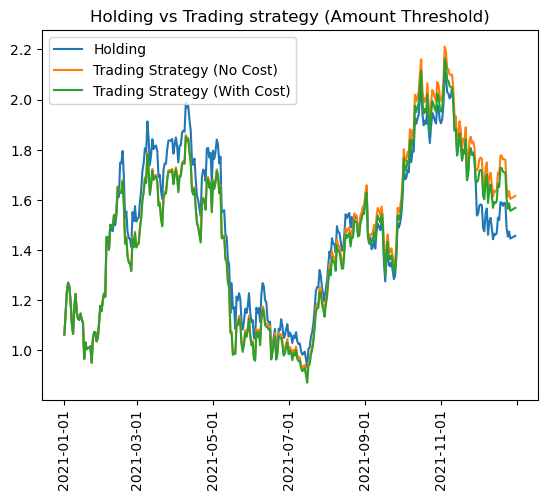

In [2333]:
# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[(check_test_df.index>='2021-01-01')&(check_test_df.index<='2021-12-31')]

### test_df에 target_df 데이터 적용
check_test_df['transaction_count'] = target_df['transaction_count']
check_test_df['transaction_amount'] = target_df['transaction_amount']
check_test_df['transaction_flag'] = target_df['transaction_flag']
check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).fillna(check_test_df.mean())
threshold = check_test_df['transaction_amount_usd'].quantile(0.96)
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_usd'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_after_4day'] = check_test_df['returns'].shift(-4).fillna(check_test_df.mean())
check_test_df['returns_after_5day'] = check_test_df['returns'].shift(-5).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_4day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

plt.title('Holding vs Trading strategy (Amount Threshold)')
plt.plot((check_test_df.returns_after_4day + 1).cumprod(), label='Holding')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (No Cost)')

print('Sharpe Ratio (Holding): ', check_test_df.returns_after_4day.mean() / check_test_df.returns_after_4day.std() * np.sqrt(252))
print('Sortino Ratio (Holding): ', calculate_sortino_ratio(check_test_df.returns_after_4day))
print('Cumulative Returns (Holding): ', (check_test_df.returns_after_4day + 1).cumprod()[-1])
print('MDD (Holding): ', calculate_mdd((check_test_df.returns_after_4day + 1).cumprod()))

print('Sharpe Ratio (Trading Strategy no cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy no cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy no cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy no cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (With Cost)')

print('Sharpe Ratio (Trading Strategy with cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy with cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy with cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy with cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

print('Count: ', len(check_test_df))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

# # # 고해상도 저장
# plt.savefig('./figure/backtesting_amount.pdf', dpi=300, bbox_inches='tight')
# plt.show()

benchmark_sharpe = check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252)


### 수수료 없이

C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(252)
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(252)
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(252)
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(252)
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(252)
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2152329449.py:40: RuntimeWarning: invali

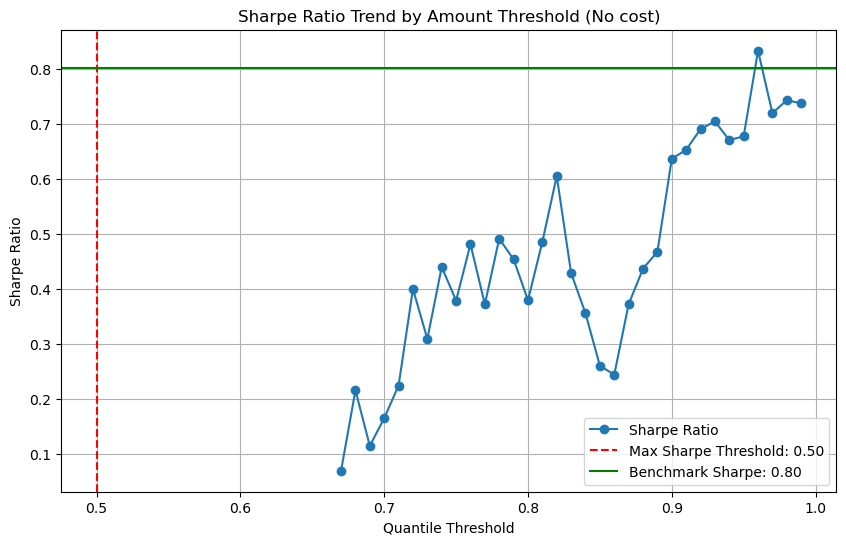

max_sharpe_ratio:  nan


In [2334]:
# Threshold별 Sharpe Ratio 추적
thresholds = np.arange(0.5, 1.0, 0.01)
sharpe_ratios = []

for threshold in thresholds:
    temp_df = check_test_df.copy()
    threshold_value = temp_df['transaction_amount_usd'].quantile(threshold)

    # 거래 플래그 생성
    temp_df['transaction_amount_trading_flag'] = temp_df['transaction_amount_usd'].apply(
        lambda x: 1 if x >= threshold_value else (-1 if x < threshold_value else 0)
    )

    # adjusted_returns 생성
    temp_df['adjusted_returns'] = 0
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag'] == -1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_4day']
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag']==1]
    # Sharpe Ratio 계산
    sharpe_ratio = calculate_sharpe_ratio(temp_df['adjusted_returns'])
    sharpe_ratios.append(sharpe_ratio)

# 최적의 threshold 찾기
max_sharpe_ratio = max(sharpe_ratios)
optimal_threshold = thresholds[sharpe_ratios.index(max_sharpe_ratio)]

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', linestyle='-', label='Sharpe Ratio')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Max Sharpe Threshold: {optimal_threshold:.2f}')
plt.axhline(y=benchmark_sharpe, color='green', linestyle='-', label=f'Benchmark Sharpe: {benchmark_sharpe:.2f}')
plt.xlabel('Quantile Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Trend by Amount Threshold (No cost)')
plt.grid(True)
plt.legend()

# # 고해상도 저장
# plt.savefig('./figure/sharpe_ratio_amount_no_cost_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()

print("max_sharpe_ratio: ", max_sharpe_ratio)

### 수수료 0.1% 가정

C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3196474059.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3196474059.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3196474059.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002' has dtype incompatible with int64, please explicitly cast to a compatible dty

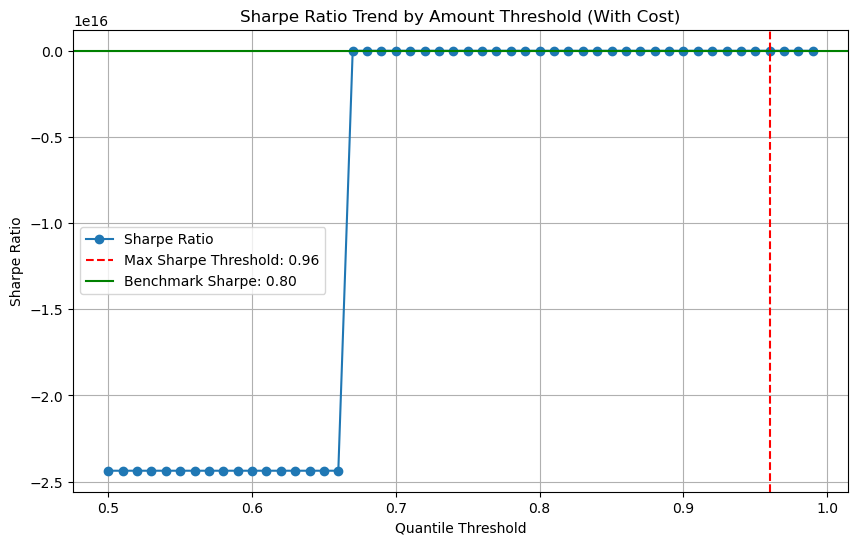

max_sharpe_ratio:  0.8017494096712531


In [2335]:


# Threshold별 Sharpe Ratio 추적
thresholds = np.arange(0.5, 1.0, 0.01)
sharpe_ratios = []

for threshold in thresholds:
    temp_df = check_test_df.copy()
    threshold_value = temp_df['transaction_amount_usd'].quantile(threshold)

    # 거래 플래그 생성
    temp_df['transaction_amount_trading_flag'] = temp_df['transaction_amount_usd'].apply(
        lambda x: 1 if x >= threshold_value else (-1 if x < threshold_value else 0)
    )

    # adjusted_returns 생성
    temp_df['adjusted_returns'] = 0
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag'] == -1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_4day']
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag']==1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
    # Sharpe Ratio 계산
    sharpe_ratio = calculate_sharpe_ratio(temp_df['adjusted_returns'])
    sharpe_ratios.append(sharpe_ratio)

# 최적의 threshold 찾기
max_sharpe_ratio = max(sharpe_ratios)
optimal_threshold = thresholds[sharpe_ratios.index(max_sharpe_ratio)]

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', linestyle='-', label='Sharpe Ratio')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Max Sharpe Threshold: {optimal_threshold:.2f}')
plt.axhline(y=benchmark_sharpe, color='green', linestyle='-', label=f'Benchmark Sharpe: {benchmark_sharpe:.2f}')
plt.xlabel('Quantile Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Trend by Amount Threshold (With Cost)')
plt.grid(True)
plt.legend()

# # 고해상도 저장
# plt.savefig('./figure/sharpe_ratio_amount_with_cost_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()

print("max_sharpe_ratio: ", max_sharpe_ratio)

### Measure Returns로 트레이딩 플래그

threshold::: 5.455272666392205e+17


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2019212258.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.12622231  0.00645032 -0.05388233 ... -0.03466997  0.00125062
  0.00125062]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지


Sharpe Ratio (Holding):  0.5691040963980184
Sortino Ratio (Holding):  0.7553928685993861
Cumulative Returns (Holding):  4.7391360480323215
MDD (Holding):  -0.81184771458817
Sharpe Ratio (Trading Strategy no cost):  0.7760556770014394
Sortino Ratio (Trading Strategy no cost):  1.0447015220138587
Cumulative Returns (Trading Strategy no cost):  14.200819539778342
MDD (Trading Strategy no cost):  -0.781330720083296
Sharpe Ratio (Trading Strategy with cost):  0.6805872871048767
Sortino Ratio (Trading Strategy with cost):  0.9546291614926156
Cumulative Returns (Trading Strategy with cost):  8.660781988100016
MDD (Trading Strategy with cost):  -0.7981589827473654
Count:  2465


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2019212258.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Holding): ', (check_test_df.returns + 1).cumprod()[-1])
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2019212258.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Trading Strategy no cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2019212258.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

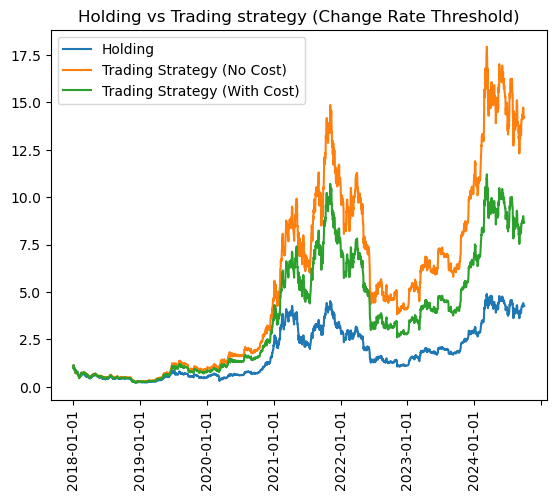

In [2336]:
# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[(check_test_df.index>='2018-01-01')&(check_test_df.index<='2024-12-31')]

### test_df에 target_df 데이터 적용
check_test_df['transaction_count'] = target_df['transaction_count']
check_test_df['transaction_amount'] = target_df['transaction_amount']
check_test_df['transaction_flag'] = target_df['transaction_flag']
check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']
check_test_df['transaction_amount_usd'] = np.where(check_test_df['transaction_amount_usd'] == 0, 1e-10, check_test_df['transaction_amount_usd'])

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).fillna(check_test_df.mean())
threshold = check_test_df['transaction_amount_returns'].quantile(0.9)
print("threshold:::", threshold)

# check test df 날짜 인덱싱
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_returns'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_after_4day'] = check_test_df['returns'].shift(-4).fillna(check_test_df.mean())
check_test_df['returns_after_5day'] = check_test_df['returns'].shift(-5).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())
# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

plt.title('Holding vs Trading strategy (Change Rate Threshold)')
plt.plot((check_test_df.returns_after_3day + 1).cumprod(), label='Holding')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (No Cost)')

print('Sharpe Ratio (Holding): ', check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252))
print('Sortino Ratio (Holding): ', calculate_sortino_ratio(check_test_df.returns))
print('Cumulative Returns (Holding): ', (check_test_df.returns + 1).cumprod()[-1])
print('MDD (Holding): ', calculate_mdd((check_test_df.returns + 1).cumprod()))

print('Sharpe Ratio (Trading Strategy no cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy no cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy no cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy no cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (With Cost)')

print('Sharpe Ratio (Trading Strategy with cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy with cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy with cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy with cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

print('Count: ', len(check_test_df))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

# # 고해상도 저장
# plt.savefig('./figure/backtesting_using_target_returns_no_cost.pdf', dpi=300, bbox_inches='tight')
# plt.show()

benchmark_sharpe = check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252)


### 연도별 백테스팅

threshold::: 0.9084167389078108
Sharpe Ratio (Holding):  0.962549211875151
Sortino Ratio (Holding):  1.552025369299536
Cumulative Returns (Holding):  1.4358770019201315
MDD (Holding):  -0.26151375053867776
Sharpe Ratio (Trading Strategy no cost):  1.5118034965382376
Sortino Ratio (Trading Strategy no cost):  2.232367131323206
Cumulative Returns (Trading Strategy no cost):  1.7803630880584136
MDD (Trading Strategy no cost):  -0.19611106581881296
Sharpe Ratio (Trading Strategy with cost):  1.2913920081551886
Sortino Ratio (Trading Strategy with cost):  2.0394332341071695
Cumulative Returns (Trading Strategy with cost):  1.6172403311760668
MDD (Trading Strategy with cost):  -0.20921487407683903
Count:  274


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\2783702375.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.04787721e-02 -1.35670459e-04 -4.00474707e-03  6.87932487e-02
 -1.79131282e-02  1.17976578e-02 -7.67478306e-02  1.52538185e-03
 -2.60371607e-02  1.86605835e-02  1.47455606e-02 -8.38820574e-03
 -3.38647048e-02  8.02201924e-03  8.88402826e-04 -2.77508368e-03
 -4.83957198e-02  8.32945394e-03  4.69401668e-03 -3.08819685e-03
  4.66058358e-02  7.10413832e-03 -2.12651140e-03  3.02547687e-02
 -8.35051856e-03 -8.40919306e-03  1.18116487e-02  2.71708477e-03
 -4.37291667e-03 -9.95580442e-03  2.95470856e-03  9.13748253e-03
  2.90181083e-02  2.11738099e-02  4.07192531e-02  1.31186858e-02
  1.14950256e-02  3.34840649e-02 -4.36081541e-03  4.21649354e-02
  1.63779750e-03  4.70528142e-03 -9.23699225e-03  9.58568346e-03
 -6.96118565e-03  9.34992804e-03 -7.83465834e-03 -1.08192208e-02
 -1.06119471e-02  3.114

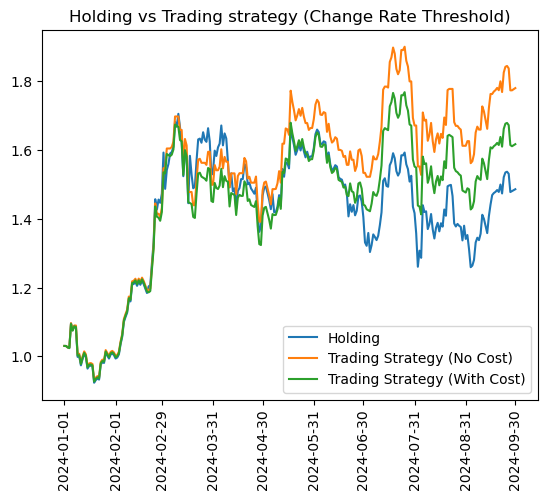

In [2337]:
year = 2024

# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[(check_test_df.index>='2018-01-01')&(check_test_df.index<='2024-12-31')]

### test_df에 target_df 데이터 적용
check_test_df['transaction_count'] = target_df['transaction_count']
check_test_df['transaction_amount'] = target_df['transaction_amount']
check_test_df['transaction_flag'] = target_df['transaction_flag']
check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']
check_test_df['transaction_amount_usd'] = np.where(check_test_df['transaction_amount_usd'] == 0, 1e-10, check_test_df['transaction_amount_usd'])

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).fillna(check_test_df.mean())

threshold_test_df = check_test_df[(check_test_df.index>=f'2018-01-01')&(check_test_df.index<=f'{year}-12-31')]

threshold = threshold_test_df['transaction_amount_returns'].quantile(0.8)
print("threshold:::", threshold)


check_test_df = check_test_df[(check_test_df.index>=f'{year}-01-01')&(check_test_df.index<=f'{year}-12-31')]


# check test df 날짜 인덱싱
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_returns'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_after_4day'] = check_test_df['returns'].shift(-4).fillna(check_test_df.mean())
check_test_df['returns_after_5day'] = check_test_df['returns'].shift(-5).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())
# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

plt.title('Holding vs Trading strategy (Change Rate Threshold)')
plt.plot((check_test_df.returns_after_3day + 1).cumprod(), label='Holding')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (No Cost)')

print('Sharpe Ratio (Holding): ', check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252))
print('Sortino Ratio (Holding): ', calculate_sortino_ratio(check_test_df.returns))
print('Cumulative Returns (Holding): ', (check_test_df.returns + 1).cumprod()[-1])
print('MDD (Holding): ', calculate_mdd((check_test_df.returns + 1).cumprod()))

print('Sharpe Ratio (Trading Strategy no cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy no cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy no cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy no cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (With Cost)')

print('Sharpe Ratio (Trading Strategy with cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy with cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy with cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy with cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

print('Count: ', len(check_test_df))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

# # 고해상도 저장
# plt.savefig('./figure/backtesting_using_target_returns_no_cost.pdf', dpi=300, bbox_inches='tight')
# plt.show()

benchmark_sharpe = check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252)


threshold::: 1.1310601594478793e+18


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3401518228.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.12622231  0.00645032 -0.05388233 ... -0.03466997  0.00125062
  0.00125062]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3401518228.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Holding): ', (check_test_df.returns + 1).cumprod()[-1])
C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3401518228.py:49: FutureWarning: Series.__

Sharpe Ratio (Holding):  0.5691040963980184
Sortino Ratio (Holding):  0.7553928685993861
Cumulative Returns (Holding):  4.7391360480323215
MDD (Holding):  -0.81184771458817
Sharpe Ratio (Trading Strategy no cost):  0.7792742691253012
Sortino Ratio (Trading Strategy no cost):  1.0554373287183678
Cumulative Returns (Trading Strategy no cost):  14.475821101987545
MDD (Trading Strategy no cost):  -0.7838480535090957
Sharpe Ratio (Trading Strategy):  0.693624417903159
Sortino Ratio (Trading Strategy):  0.9739835090216504
Cumulative Returns (Trading Strategy):  9.281611219206248
MDD (Trading Strategy):  -0.7992806793400414
Count:  2465


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3401518228.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Cumulative Returns (Trading Strategy): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])


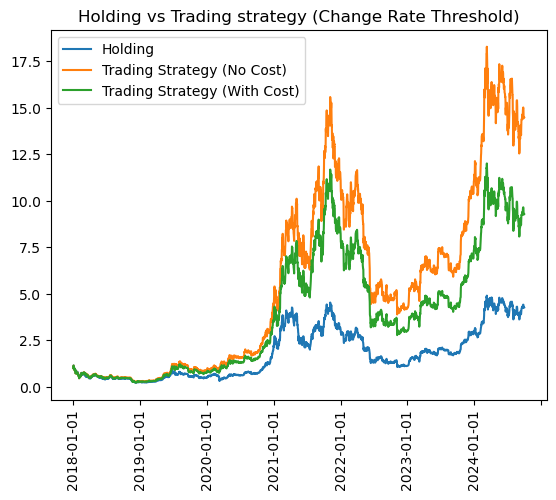

In [2338]:
# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[check_test_df.index>='2017-01-01']

### test_df에 target_df 데이터 적용
check_test_df['transaction_count'] = target_df['transaction_count']
check_test_df['transaction_amount'] = target_df['transaction_amount']
check_test_df['transaction_flag'] = target_df['transaction_flag']
check_test_df['transaction_amount_usd'] = check_test_df['transaction_amount'] * check_test_df['close']

check_test_df['transaction_amount_usd'] = np.where(check_test_df['transaction_amount_usd'] == 0, 1e-10, check_test_df['transaction_amount_usd'])

# trading flag 생성
check_test_df['transaction_amount_returns'] = check_test_df['transaction_amount_usd'].pct_change(1).shift(0).fillna(check_test_df.mean())
threshold = check_test_df['transaction_amount_returns'].quantile(0.91)
print("threshold:::", threshold)
check_test_df['transaction_amount_trading_flag'] = check_test_df['transaction_amount_returns'].apply(lambda x: 1 if x >= threshold else (-1 if x < threshold else (-1 if x == np.inf else 0)))

# 지연 수익률 계산, carrying 수익률
check_test_df['returns'] = check_test_df['close'].pct_change(1).fillna(check_test_df.mean())
check_test_df['returns_after_2day'] = check_test_df['returns'].shift(-2).fillna(check_test_df.mean())
check_test_df['returns_after_3day'] = check_test_df['returns'].shift(-3).fillna(check_test_df.mean())
check_test_df['returns_after_4day'] = check_test_df['returns'].shift(-4).fillna(check_test_df.mean())
check_test_df['returns_after_5day'] = check_test_df['returns'].shift(-5).fillna(check_test_df.mean())
check_test_df['returns_during_2day'] = check_test_df['close'].pct_change(2).shift(-2).fillna(check_test_df.mean())
check_test_df['returns_during_3day'] = check_test_df['close'].pct_change(3).shift(-3).fillna(check_test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
check_test_df = check_test_df.replace([np.inf, -np.inf], np.nan)
check_test_df = check_test_df.fillna(check_test_df.mean())

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day'] # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

plt.title('Holding vs Trading strategy (Change Rate Threshold)')
plt.plot((check_test_df.returns_after_3day + 1).cumprod(), label='Holding')
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (No Cost)')

print('Sharpe Ratio (Holding): ', check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252))
print('Sortino Ratio (Holding): ', calculate_sortino_ratio(check_test_df.returns))
print('Cumulative Returns (Holding): ', (check_test_df.returns + 1).cumprod()[-1])
print('MDD (Holding): ', calculate_mdd((check_test_df.returns + 1).cumprod()))

print('Sharpe Ratio (Trading Strategy no cost): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy no cost): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy no cost): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy no cost): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
plt.plot((check_test_df.adjusted_returns + 1).cumprod(), label='Trading Strategy (With Cost)')

print('Sharpe Ratio (Trading Strategy): ', check_test_df.adjusted_returns.mean() / check_test_df.adjusted_returns.std() * np.sqrt(252))
print('Sortino Ratio (Trading Strategy): ', calculate_sortino_ratio(check_test_df.adjusted_returns))
print('Cumulative Returns (Trading Strategy): ', (check_test_df.adjusted_returns + 1).cumprod()[-1])
print('MDD (Trading Strategy): ', calculate_mdd((check_test_df.adjusted_returns + 1).cumprod()))

print('Count: ', len(check_test_df))

plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()  # 현재 그래프의 X축 가져오기
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 자동으로 적절한 간격 설정

# # 고해상도 저장
# plt.savefig('./figure/backtesting_returns.pdf', dpi=300, bbox_inches='tight')
# plt.show()

benchmark_sharpe = check_test_df.returns.mean() / check_test_df.returns.std() * np.sqrt(252)


C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3959574354.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-5.38823266e-02 -7.72438194e-02 -1.11913861e-01  3.78607394e-02
 -5.17248417e-02  4.81929857e-03 -1.94973682e-01  1.15465125e-01
 -9.92145276e-02 -6.67779705e-02  3.63660020e-03 -7.71972400e-03
  3.38482290e-02 -9.00799929e-02 -3.81038797e-02  3.68453617e-02
 -1.52089053e-01  1.02615422e-01 -1.72663958e-02  1.06569164e-01
  5.82117018e-02  1.59888561e-02  7.41152009e-02  4.30287815e-03
  3.26163179e-02 -4.30883700e-02 -1.07803282e-02  2.37349864e-02
 -2.29235579e-02  5.74468662e-02  1.08974359e-02  4.40665429e-03
 -6.43897328e-02 -6.44157417e-02  8.70388656e-02  2.04351169e-03
  3.60441860e-02 -1.82442319e-02 -3.94660391e-02 -3.96592740e-02
 -1.60169615e-02  4.94912132e-02  4.45981831e-02  9.01998018e-03
  1.39378670e-01 -5.75413354e-03  4.45042574e-02 -3.47193297e-02
  3.65224185e-02  1.284

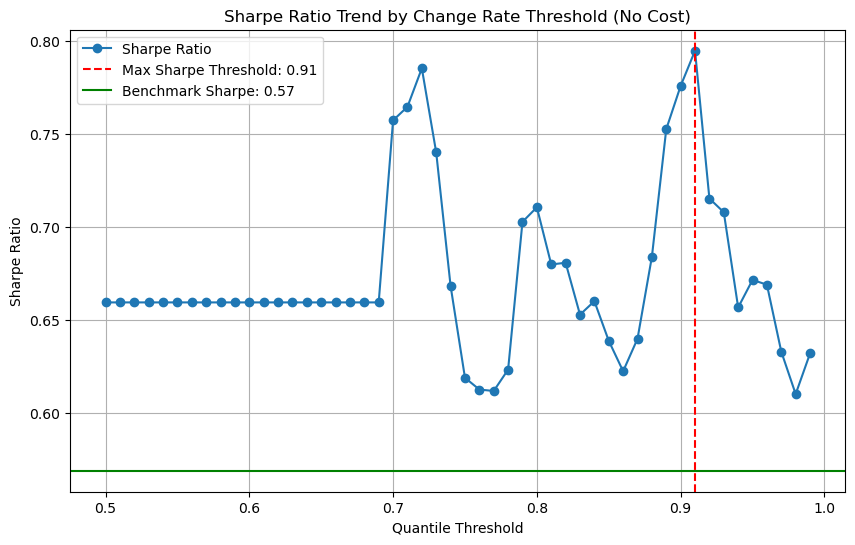

max_sharpe_ratio:  0.7948326796242942


In [2339]:
# Threshold별 Sharpe Ratio 추적
thresholds = np.arange(0.5, 1.0, 0.01)
sharpe_ratios = []

for threshold in thresholds:
    temp_df = check_test_df.copy()
    threshold_value = temp_df['transaction_amount_returns'].quantile(threshold)

    # 거래 플래그 생성
    temp_df['transaction_amount_trading_flag'] = temp_df['transaction_amount_returns'].apply(
        lambda x: 1 if x >= threshold_value else (-1 if x < threshold_value else 0)
    )

    # adjusted_returns 생성
    temp_df['adjusted_returns'] = 0
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag'] == -1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day']
    # trading_price_df = temp_df[temp_df['transaction_amount_trading_flag']==1]
    # temp_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
    # Sharpe Ratio 계산
    sharpe_ratio = calculate_sharpe_ratio(temp_df['adjusted_returns'])
    sharpe_ratios.append(sharpe_ratio)

# 최적의 threshold 찾기
max_sharpe_ratio = max(sharpe_ratios)
optimal_threshold = thresholds[sharpe_ratios.index(max_sharpe_ratio)]

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', linestyle='-', label='Sharpe Ratio')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Max Sharpe Threshold: {optimal_threshold:.2f}')
plt.axhline(y=benchmark_sharpe, color='green', linestyle='-', label=f'Benchmark Sharpe: {benchmark_sharpe:.2f}')
plt.xlabel('Quantile Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Trend by Change Rate Threshold (No Cost)')
plt.grid(True)
plt.legend()

# # 고해상도 저장
# plt.savefig('./figure/sharpe_ratio_returns_no_cost_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()

print("max_sharpe_ratio: ", max_sharpe_ratio)

C:\Users\slaye\AppData\Local\Temp\ipykernel_40588\3843242942.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-5.38823266e-02 -7.72438194e-02 -1.11913861e-01  3.78607394e-02
 -5.17248417e-02  4.81929857e-03 -1.94973682e-01  1.15465125e-01
 -9.92145276e-02 -6.67779705e-02  3.63660020e-03 -7.71972400e-03
  3.38482290e-02 -9.00799929e-02 -3.81038797e-02  3.68453617e-02
 -1.52089053e-01  1.02615422e-01 -1.72663958e-02  1.06569164e-01
  5.82117018e-02  1.59888561e-02  7.41152009e-02  4.30287815e-03
  3.26163179e-02 -4.30883700e-02 -1.07803282e-02  2.37349864e-02
 -2.29235579e-02  5.74468662e-02  1.08974359e-02  4.40665429e-03
 -6.43897328e-02 -6.44157417e-02  8.70388656e-02  2.04351169e-03
  3.60441860e-02 -1.82442319e-02 -3.94660391e-02 -3.96592740e-02
 -1.60169615e-02  4.94912132e-02  4.45981831e-02  9.01998018e-03
  1.39378670e-01 -5.75413354e-03  4.45042574e-02 -3.47193297e-02
  3.65224185e-02  1.284

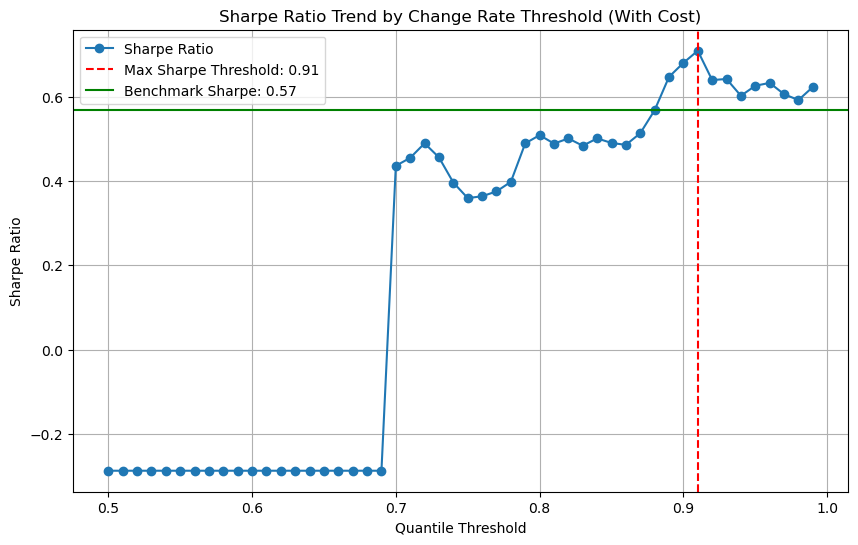

max_sharpe_ratio:  0.7092834489129615


In [2340]:
# Threshold별 Sharpe Ratio 추적
thresholds = np.arange(0.5, 1.0, 0.01)
sharpe_ratios = []

for threshold in thresholds:
    temp_df = check_test_df.copy()
    threshold_value = temp_df['transaction_amount_returns'].quantile(threshold)

    # 거래 플래그 생성
    temp_df['transaction_amount_trading_flag'] = temp_df['transaction_amount_returns'].apply(
        lambda x: 1 if x >= threshold_value else (-1 if x < threshold_value else 0)
    )

    # adjusted_returns 생성
    temp_df['adjusted_returns'] = 0
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag'] == -1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_3day']
    trading_price_df = temp_df[temp_df['transaction_amount_trading_flag']==1]
    temp_df.loc[trading_price_df.index, 'adjusted_returns'] = -0.002
    # Sharpe Ratio 계산
    sharpe_ratio = calculate_sharpe_ratio(temp_df['adjusted_returns'])
    sharpe_ratios.append(sharpe_ratio)

# 최적의 threshold 찾기
max_sharpe_ratio = max(sharpe_ratios)
optimal_threshold = thresholds[sharpe_ratios.index(max_sharpe_ratio)]

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o', linestyle='-', label='Sharpe Ratio')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Max Sharpe Threshold: {optimal_threshold:.2f}')
plt.axhline(y=benchmark_sharpe, color='green', linestyle='-', label=f'Benchmark Sharpe: {benchmark_sharpe:.2f}')
plt.xlabel('Quantile Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Trend by Change Rate Threshold (With Cost)')
plt.grid(True)
plt.legend()

# # 고해상도 저장
# plt.savefig('./figure/sharpe_ratio_returns_with_cost_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()

print("max_sharpe_ratio: ", max_sharpe_ratio)